## Upload Data Files:

* Upload the data files for each branch in CSV format.
* Ensure the files are accessible and note their paths.

Update list_of_places:
* Replace the existing paths in the list_of_places variable with the paths of the uploaded CSV files.
* Example:

```
# list_of_places = [
    "/content/Bayridge.csv",
    "/content/Dekalb.csv",
    "/content/Dumbo.csv",
    "/content/Myrtle.csv",
    "/content/Vanderbiltt.csv"]
```
* Modify the start and end dates for the sales period.
* Example:

```
# Start and end of sales parameters
first_day = '10-15-2023'
last_day = '10-28-2023'
```

* Execute the process_sheets function with the updated data and date range.
* Example:

```
# result_dataframe = process_sheets(list_of_places, first_day, last_day)
```
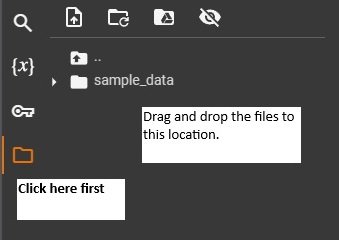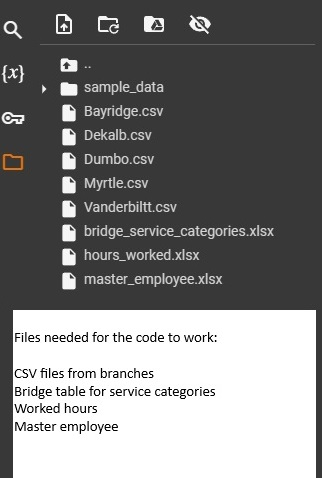

In [ ]:
import pandas as pd
import numpy as np
import os
import re
import numpy as np

def remove_suffix(nome):
    # Function to remove suffixes like "I", "II", etc.
    return re.sub(r' [IVXLCDM]+$', '', nome)

def fix_value(valor):
    # Checks if the value contains two commas
    if valor.count(',') == 2:
        # Replaces the first comma with a dot
        valor = valor.replace(',', '.', 1)
    return valor

def process_sheets(lista_caminhos, df_dates):
    # List to store processed DataFrames from each sheet
    dataframes_processados = []

    for caminho in lista_caminhos:
        # Extracting the branch name from the path
        nome_filial = os.path.splitext(os.path.basename(caminho))[0]

        # Extracting data from the spreadsheet
        db = pd.read_csv(caminho, delimiter=',', encoding='ISO-8859-1')

         # Transformations
        db.columns.values[0] = 'service'
        db.drop(db.columns[-1], axis=1, inplace=True)
        db = db.fillna(0)
        db = db.drop(0)

        # Adicionando as colunas 'first_day' e 'last_day' do DataFrame de datas ao DataFrame atual
        db['first_day'] = df_dates.iloc[0, 0]
        db['last_day'] = df_dates.iloc[0, -1]

        # Separating the necessary data
        df1 = db[db['metric'] == "serviceCategoryAmount"]
        df2 = db[db['metric'] == "productsAmount"]
        df3 = db[db['metric'] == "courseServiceAmount"]
        df4 = db[db['metric'] == "tips"]
        # Concatenating DataFrames
        df_concatenado = pd.concat([df1, df2, df3, df4], ignore_index=True)

        # Restructuring the DataFrame
        df_melted = df_concatenado.melt(id_vars=['first_day', 'last_day', 'service', 'metric'],
                                        var_name='employee', value_name='value')
        df_melted = df_melted[['first_day', 'last_day', 'service', 'metric', 'employee', 'value']]

        # Applying the function to remove suffixes from names
        df_melted['employee'] = df_melted['employee'].apply(remove_suffix)
        df_melted['employee'] = df_melted['employee'].str.title()

        # Removing commas and converting to integer
        df_melted['value'] = df_melted['value'].str.replace('.', ',')

        # Applying the value correction
        df_melted['value'] = df_melted['value'].apply(fix_value)

        # Removing dots from the 'value' column
        df_melted['value'] = df_melted['value'].str.replace('.', '')

        # Removing commas and replacing with a dot
        df_melted['value'] = df_melted['value'].str.replace(',', '.')

        # Converting to float
        df_melted['value'] = df_melted['value'].astype(float)


        # Adding the 'branch' column to the DataFrame
        df_melted['filial'] = nome_filial

        # Adding the 'branch' column to the DataFrame
        df_melted = df_melted[['first_day', 'last_day', 'filial', 'service', 'metric', 'employee', 'value']]

        # Adding the processed DataFrame to the list
        dataframes_processados.append(df_melted)

    # Returning the resulting DataFrame
    df_resultado = pd.concat(dataframes_processados, ignore_index=True)
    return df_resultado

In [ ]:
# List of spreadsheet paths
list_of_places = [
    "/content/Bay Ridge.csv",
    "/content/Dekalb.csv",
    "/content/Dumbo.csv",
    "/content/Myrtle.csv",
    "/content/Vanderbilt.csv",
    "/content/Fulton.csv"
    # Add more paths as needed
]

df_dates = pd.read_excel("/content/Tabela_Datas.xlsx")
database_01 = process_sheets(list_of_places, df_dates)
database_01.to_excel("/content/Database.xlsx", index= False)

<ipython-input-11-d56e1e9fd8bf>:57: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_melted['value'] = df_melted['value'].str.replace('.', ',')
<ipython-input-11-d56e1e9fd8bf>:63: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_melted['value'] = df_melted['value'].str.replace('.', '')
<ipython-input-11-d56e1e9fd8bf>:57: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_melted['value'] = df_melted['value'].str.replace('.', ',')
<ipython-input-11-d56e1e9fd8bf>:63: FutureWarning: The default value of regex will change from 

# Instructions for Updating Employee ID in Final Database:

* Ensure that tabela_final_path points to the correct path of your existing final database (Excel file).
* Update bridge_path to the path of the Excel file containing the bridge table with employee IDs.

```
# Path to the final table
tabela_final_path = "/content/Database.xlsx"

# Path to the bridge table
bridge_path = "/content/master_employee.xlsx"
```

* Call the Function:
* Execute the add_id function with the updated paths.
* Example:

```
# Calling the function
add_id(tabela_final_path, bridge_path)

```



In [ ]:
def add_service_category(tabela_final_path, bridge_path):
    # Reading the bridge table
    bridge_table = pd.read_excel(bridge_path)

    # Reading the final table
    tabela_final = pd.read_excel(tabela_final_path)

    # Adding the 'service category' column to the final table
    tabela_final['service category'] = tabela_final['service'].map(bridge_table.set_index('service')['service category'])

    # Identify services not present in the bridge table
    missing_services = tabela_final.loc[tabela_final['service category'].isnull(), 'service'].unique()

    if len(missing_services) > 0:
        # Creating a DataFrame with missing services
        missing_services_df = pd.DataFrame({'service': missing_services, 'service category': 'Not Found'})

        # Exporting missing services DataFrame to Excel
        missing_services_df.to_excel("/content/missing_services.xlsx", index=False)

    # Filling null values in the 'service category' column with 'Tips'
    tabela_final['service category'] = tabela_final['service category'].fillna('Tips')

    # Reordering the columns
    colunas_ordenadas = ['first_day', 'last_day', 'filial', 'service category', 'service', 'metric', 'employee', 'value']
    tabela_final = tabela_final[colunas_ordenadas]

    # Saving the final table with the new column order to a new Excel file
    tabela_final.to_excel(tabela_final_path, index=False)

# Path to the final table
tabela_final_path = "/content/Database.xlsx"

# Path to the bridge table
bridge_path = "/content/bridge_service_categories.xlsx"

# Calling the function
add_service_category(tabela_final_path, bridge_path)

In [ ]:
pd.read_excel("/content/Database.xlsx")

,first_day,last_day,filial,service category,service,metric,employee,value
0,2024-01-07,2024-01-20,Bay Ridge,Treatment,B3 Treatments,serviceCategoryAmount,House .,0.00
1,2024-01-07,2024-01-20,Bay Ridge,Hair,Color,serviceCategoryAmount,House .,60.00
2,2024-01-07,2024-01-20,Bay Ridge,Hair,Cut,serviceCategoryAmount,House .,0.00
3,2024-01-07,2024-01-20,Bay Ridge,Hair,Employee,serviceCategoryAmount,House .,70.00
4,2024-01-07,2024-01-20,Bay Ridge,Hair,Event Styling,serviceCategoryAmount,House .,0.00
...,...,...,...,...,...,...,...,...
2220,2024-01-07,2024-01-20,Fulton,Treatment,Single Process,courseServiceAmount,Natasha Speth,0.00
2221,2024-01-07,2024-01-20,Fulton,Hair,Barbering,courseServiceAmount,Natasha Speth,0.00
2222,2024-01-07,2024-01-20,Fulton,Hair,Haircut,courseServiceAmount,Natasha Speth,0.00
2223,2024-01-07,2024-01-20,Fulton,Hair,Blow Dry,courseServiceAmount,Natasha Speth,0.00


# Instructions for Adding Employee ID to Final Database:

* Update tabela_final_path and bridge_path:
* Ensure that tabela_final_path points to the correct path of your existing final database (Excel file).
* Update bridge_path to the path of the Excel file containing the bridge table with employee IDs.



```
# Path to the final table
tabela_final_path = "/content/Database.xlsx"

# Path to the bridge table
bridge_path = "/content/master_employee.xlsx"

```

* Call the Function:
* Execute the add_id function with the updated paths.
* Example:



```
# Calling the function
add_id(tabela_final_path, bridge_path)

```




In [ ]:
def add_id(tabela_final_path, bridge_path):
    # Reading the bridge table
    bridge_table = pd.read_excel(bridge_path)

    # Reading the final table
    tabela_final = pd.read_excel(tabela_final_path)

    # Adding the 'id' column to the final table
    tabela_final['id'] = tabela_final['employee'].map(bridge_table.set_index('employee')['id'])

    # Filling null values in the 'id' column with 'Need ID'
    tabela_final['id'] = tabela_final['id'].fillna('Need ID')

    # Missing Employees
    missing_employees_df = tabela_final[tabela_final['id'] == 'Need ID'][['employee', 'id']]
    missing_employees_df = missing_employees_df.drop_duplicates(subset='employee')
    missing_employees_df.to_excel("/content/missing_employees.xlsx", index=False)

    # Reordering the columns
    colunas_ordenadas = ['id', 'employee', 'first_day', 'last_day', 'filial', 'service category', 'service', 'metric', 'value']
    tabela_final = tabela_final[colunas_ordenadas]

    # Saving the final table with the new column order to a new Excel file
    tabela_final.to_excel(tabela_final_path, index=False)




# Path to the final table
tabela_final_path = "/content/Database.xlsx"

# Path to the bridge table
bridge_path = "/content/master_employee.xlsx"

# Calling the function
add_id(tabela_final_path, bridge_path)


# Instructions for Summarizing Worked Hours:

* Update path_hour and path_master_employee:
* Ensure that path_hour points to the correct path of your existing hourly worked data (Excel file).
* Update path_master_employee to the path of the Excel file containing the master employee data.



```
# Path to the hourly worked data
path_hour = "/content/hours_worked.xlsx"

# Path to the master employee data
path_master_employee = "/content/master_employee.xlsx"

```

* Call the Function:
* Execute the hour_worked function with the updated paths.
* Example:



```
# Calling the function
hour_worked(path_hour, path_master_employee)

```





In [ ]:
def hour_worked(path_hour, path_master_employee):
    # Reading the DataFrames
    database = pd.read_excel(path_hour)
    database_employee = pd.read_excel(path_master_employee)

    # Creating the 'employee' column in 'hours_database'
    database['employee'] = database['First Name'] + ' ' + database['Last Name']

    # Grouping and summing the worked hours
    summarized_db = database.groupby('employee')['Total Hours Worked'].sum().reset_index()

    # Merging with 'employee_database' using the 'employee' column
    summarized_db = pd.merge(summarized_db, database_employee[['employee', 'id']], on='employee', how='left')

    # Saving the result to Excel
    summarized_db.to_excel("/content/hours_worked_summ.xlsx", index=False)

# Example of usage
hour_worked("/content/hours_worked.xlsx", "/content/master_employee.xlsx")


# Instructions for Calculating Commissions:

* Update File Paths:
* Ensure that path_database, path_master_employee, and path_hours_summ point to the correct paths of your database, master employee data, and summarized hours data (Excel files), respectively.



```
# File paths
path_database = "/content/your_database.xlsx"
path_master_employee = "/content/your_master_employee.xlsx"
path_hours_summ = "/content/hours_worked_summ.xlsx"

```
* Call the Function:
* Execute the calculation function with the updated file paths.
* Example:



```
# Calling the function
result_database = calculation(path_database, path_master_employee, path_hours_summ)

```

* Review Results:
* The function returns a DataFrame (result_database) containing calculated commissions and relevant information.
* Inspect the DataFrame to ensure accurate commission calculations.

* Output DataFrame:

* The result_database DataFrame contains columns such as 'employee', 'id', 'total_retail', 'total_service', 'service_and_retail', 'retail_commission', 'service_commission_total', 'salary', and 'Tips'.



## Testes

In [ ]:
def calculation(path_database, path_master_employee, path_hours_summ):
    pd.set_option('display.max_columns', None)

    database = pd.read_excel(path_database)
    master_employee = pd.read_excel(path_master_employee)
    hours = pd.read_excel(path_hours_summ)

    # Value Comiission
    database_temp = database.copy()
    database_temp['ordem'] = database_temp.groupby(['id', 'employee', 'service category']).cumcount()
    # Pivot the DataFrame
    database_temp = database_temp.pivot_table(index=['id', 'employee', 'ordem'], columns='service category', values='value').reset_index()
    # Remove column 'ordem'
    database_temp = database_temp.drop(columns='ordem')
    database_temp.columns.name = None
    # Group by 'id' and sum all other columns
    database_temp = database_temp.groupby('id').sum().reset_index()
    # Merge DF
    database_temp = pd.merge(database_temp, master_employee, on='id', how='left')
    database_temp = pd.merge(database_temp, hours[['id', 'Total Hours Worked']], on='id', how='left')


    # Fazer o Merge com summer hours e incluir na lista em baixo
    database_temp['total_service'] = database_temp['Hair'] + database_temp['Treatment'] + database_temp['Makeup']
    database_temp['salary_hours_worked'] = database_temp['salary_hour'] * database_temp['Total Hours Worked']
    # New Order
    new_order_columns_01= ['employee','id','Retail','retail_comission_q_amt','retail_comission_q_percentage', 'retail_comission', 'Hair', 'Treatment', 'Makeup',
         'total_service','service_category','house_service_treatment', 'house_service_makeup', 'house_service_hair',
         'house_add', 'service_treatment_comission', 'service_makeup_comission',
         'service_hair_comission', 'salary_hour' ,'Total Hours Worked','salary_hours_worked','Tips']
    database_temp = database_temp[new_order_columns_01]



    # RETAIL COMMISSION

    ## Calculation
    condition1 = database_temp['total_service'] < database_temp['retail_comission_q_amt']
    condition2 = database_temp['Retail'] < (database_temp['total_service'] * database_temp['retail_comission_q_percentage'])

    database_temp.loc[~condition1 & ~condition2,'total_retail_comission'] = database_temp['Retail'] * database_temp['retail_comission']




    # SERVICE COMMISSION
    ## Condition 1: If retail_category is equal to 1
    condition_1 = database_temp['service_category'] == 1
    #database_temp.loc[condition_1, 'service_comission'] = round((database_temp.loc[condition_1, 'total_service']* (1- database_temp.loc[condition_1, 'house_service_treatment'])) * database_temp.loc[condition_1, 'service_treatment_comission'],2)
    database_temp.loc[condition_1, 'service_comission'] = ((database_temp.loc[condition_1, 'total_service'] - (((database_temp.loc[condition_1, 'total_service'] * (database_temp.loc[condition_1, 'house_service_treatment']) + database_temp.loc[condition_1, 'house_add'])))) * database_temp.loc[condition_1, 'service_treatment_comission'])

    ## Condition 2: If service_category is equal to 2
    condition_2 = database_temp['service_category'] == 2
    database_temp.loc[condition_2, 'service_comission'] = round(
        ((database_temp.loc[condition_2, 'Hair'] * (1 - database_temp.loc[condition_2, 'house_service_hair'])) * (database_temp.loc[condition_2, 'service_hair_comission'])) +
        ((database_temp.loc[condition_2, 'Treatment'] * (1 - database_temp.loc[condition_2, 'house_service_treatment'])) * (database_temp.loc[condition_2, 'service_treatment_comission'])) +
        ((database_temp.loc[condition_2, 'Makeup'] * (1 - database_temp.loc[condition_2, 'house_service_makeup'])) * (database_temp.loc[condition_2, 'service_makeup_comission'])),
        2)

    ## Condition 3: If service_category is equal to 3
    condition_3 = database_temp['service_category'] == 3
    # Salary calculation with discount and commission
    database_temp.loc[condition_3, 'salary_commission_temp'] = (database_temp.loc[condition_3, 'salary_hours_worked'] * (1 - 0.12)) * 0.4
    # Service commission calculation with discount
    database_temp.loc[condition_3, 'total_service_temp'] = (database_temp.loc[condition_3, 'total_service'] * (1 - 0.12)) * 0.4
    # Final commission calculation (either service commission or work commission)
    database_temp.loc[condition_3, 'total_service_temp'] = round(database_temp[['salary_commission_temp', 'total_service_temp']].max(axis=1),2)
    #database_temp.drop(['salary_commission_temp','total_service_temp'], axis = 1, inplace = True)


    ## Condition 4: If service_category is equal to 4 and Treatment is more than 800
    condition_4 = (database_temp['service_category'] == 4) & (database_temp['Treatment'] > 800)
    database_temp.loc[condition_4, 'service_comission'] = round(database_temp.loc[condition_4, 'Treatment'] * 0.1, 2)

    ## Condition 5: If service_category is equal to 5 and the apprentice doubles their hourly rate in services
    condition_5 = (database_temp['service_category'] == 5) & (database_temp['salary_hours_worked'] * 2 < database_temp['total_service'])
    database_temp.loc[condition_5, 'service_comission'] = round((database_temp.loc[condition_5, 'total_service'] - database_temp.loc[condition_5, 'salary_hours_worked'] * 2) * 0.2, 2)



    database_temp.fillna(0, inplace = True)
    # Remover linhas duplicadas com base na coluna 'ID'
    database_temp.drop_duplicates(subset='id', inplace=True)

    #Arredondando
    database_temp['service_comission'] = database_temp['service_comission'].round(2)


    return database_temp



In [ ]:
final = calculation("/content/Database.xlsx","/content/master_employee.xlsx","/content/hours_worked_summ.xlsx")
final.to_excel("/content/final_database.xlsx", index= False)
final


<ipython-input-17-2bd5e2a32ef6>:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  database_temp = database_temp.groupby('id').sum().reset_index()


,employee,id,Retail,retail_comission_q_amt,retail_comission_q_percentage,retail_comission,Hair,Treatment,Makeup,total_service,service_category,house_service_treatment,house_service_makeup,house_service_hair,house_add,service_treatment_comission,service_makeup_comission,service_hair_comission,salary_hour,Total Hours Scheduled,salary_hours_worked,Tips,total_retail_comission,service_comission,salary_commission_temp,total_service_temp
0,Kiara Alcaraz,2,0.00,500,0.10,0.10,0.00,0.00,0.0,0.00,4,0.00,0.00,0.00,0,0.10,0.00,0.00,16.000000,60.00,960.000,30.75,0.00,0.00,0.00,0.00
1,Darnelle Antenor,3,0.00,0,0.00,0.10,340.00,160.00,0.0,500.00,4,0.00,0.00,0.00,0,0.10,0.00,0.00,16.000000,55.50,888.000,10.00,0.00,0.00,0.00,0.00
3,Diamonique Antley,4,471.60,500,0.10,0.10,8540.64,400.00,0.0,8940.64,3,0.12,0.12,0.12,0,0.40,0.40,0.40,0.000000,81.00,0.000,1537.58,0.00,0.00,0.00,3147.11
5,Michaella Blissett-Williams,8,201.00,0,0.00,0.00,1246.43,110.00,0.0,1356.43,1,0.00,0.00,0.00,0,0.00,0.00,0.00,50.000000,0.00,0.000,274.60,0.00,0.00,0.00,0.00
6,Jackie Chan,10,297.38,0,0.10,0.10,5793.18,160.00,0.0,5953.18,1,0.12,0.12,0.12,0,0.40,0.40,0.40,0.000000,60.50,0.000,1019.92,0.00,2095.52,0.00,0.00
8,Sarah Culmo,11,195.00,0,0.10,0.10,6348.29,131.54,0.0,6479.83,1,0.12,0.12,0.12,0,0.40,0.40,0.40,0.000000,72.50,0.000,988.22,0.00,2280.90,0.00,0.00
9,Ariana Cunningham,12,188.00,0,0.10,0.10,3734.57,240.00,0.0,3974.57,1,0.12,0.12,0.12,0,0.43,0.43,0.43,0.000000,37.25,0.000,602.25,0.00,1503.98,0.00,0.00
10,Sachi Edenfield,14,776.00,0,0.10,0.10,11588.69,339.17,0.0,11927.86,1,0.12,0.12,0.12,0,0.50,0.50,0.50,0.000000,70.00,0.000,1645.25,0.00,5248.26,0.00,0.00
13,Ari Hughes,17,104.72,500,0.10,0.10,2494.00,80.00,0.0,2574.00,3,0.12,0.12,0.12,0,0.40,0.40,0.40,0.000000,54.25,0.000,296.18,0.00,0.00,0.00,906.05
15,Nicole Juran,18,435.00,500,0.10,0.10,5041.21,351.67,0.0,5392.88,3,0.12,0.12,0.12,0,0.40,0.40,0.40,0.000000,86.66,0.000,858.83,0.00,0.00,0.00,1898.29
